In [18]:
import torch
import torch.nn.functional as F
import numpy as np
import gzip
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist

In [2]:
X, y = loadlocal_mnist(
    images_path='mnist/train-images.idx3-ubyte', 
    labels_path='mnist/train-labels.idx1-ubyte')

(<matplotlib.image.AxesImage at 0x78a76db36420>, np.uint8(2))

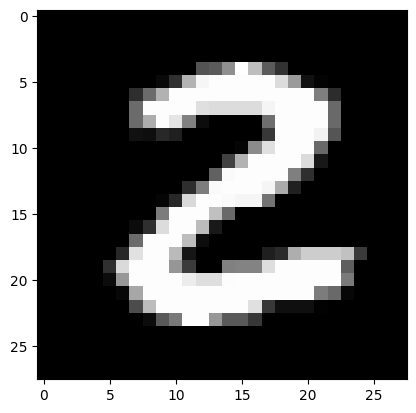

In [3]:
idx = 25
plt.imshow(X[idx, :].reshape(28, 28), cmap='grey'), y[idx]

In [4]:
#expanding conv into matmul

t = torch.arange(64, dtype=torch.float32).reshape((1, 1, 8, 8))
t, t.shape

(tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11., 12., 13., 14., 15.],
           [16., 17., 18., 19., 20., 21., 22., 23.],
           [24., 25., 26., 27., 28., 29., 30., 31.],
           [32., 33., 34., 35., 36., 37., 38., 39.],
           [40., 41., 42., 43., 44., 45., 46., 47.],
           [48., 49., 50., 51., 52., 53., 54., 55.],
           [56., 57., 58., 59., 60., 61., 62., 63.]]]]),
 torch.Size([1, 1, 8, 8]))

In [5]:
unfold = torch.nn.Unfold(kernel_size=(2, 2), stride=2)
tu = unfold(t).unsqueeze(dim=0)

In [6]:
tu.shape

torch.Size([1, 1, 4, 16])

In [7]:
c = torch.randn(size=(5, 4))

In [8]:
out = torch.matmul(c, tu)

In [9]:
out.shape

torch.Size([1, 1, 5, 16])

In [10]:
#forward pass conv and max pool

def conv(X, conv, b=None):
    k = conv.shape[-1] #k^2 conv kernel
    C_out = conv.shape[0]
    Xu = F.unfold(X, kernel_size=(k, k)).unsqueeze(dim=1)
    out = torch.matmul(conv.view(C_out, -1))
    if b:
        out += b
    return out

def max_pool():
    pass

In [65]:
x_in = torch.tensor(X[0:10], dtype=torch.float32).view(-1, 1, 28, 28)

In [12]:
x_in.shape

torch.Size([10, 1, 28, 28])

In [29]:
tu = F.unfold(x_in, kernel_size=(3, 3)).unsqueeze(dim=1)

In [33]:
tu.shape #shape B x C * K^2 * L
#note L is a perfect square if conv kernel is square

torch.Size([10, 1, 9, 676])

In [28]:
#define conv kernels
convs = torch.randn(size=(5, 1, 3, 3))
convs.shape, convs.view(5, -1).shape

(torch.Size([5, 1, 3, 3]), torch.Size([5, 9]))

In [37]:
out = torch.matmul(convs.view(5, -1), tu)

In [64]:
out.shape

torch.Size([10, 1, 5, 676])

In [107]:
#performing max pooling

#set stride = kernel size to have fully separated kernels
pool = out.view(10, 5, 26, 26).unfold(2, 2, 2).unfold(3, 2, 2)
max_pool = pool.amax(dim=(-2, -1))

Expected shapes:
input: N x C_in x W x H
- N: batch size
- C_in: channels (eg 3 for RGB image, or 5 if the previous conv layer had 5 filters)
- W, H: image width and height

unfolded input: N x C*K^2 x L
- N: batch size, same as above
- C_in: same as above
- K: conv kernel size (assumes square conv kernel), so conv kernel has K^2 elems
- L: number of  "windows", determined based on image and kernel sizes

conv matrix: C_out, C_in, K, K
- C_out: # of kernel filters
- C_in: same as above
- K: conv kernel size, same as above

conv output: N x C_out x W_out x H_out
- N: above
- C_out: above
- W_out: new image width, determined by image width and kernel size
- H_out: new image height, determined by image height and kernel size

max pooling: N x C_out x W_out / subsampling ratio x H_out / subsampling ratio
- subsampling ratio: size of input field used to subsample from, common methods are max and mean